# Anomaly detection

**Purpose**: In this notebook, I am going to describe three different (basic) anomaly detection method, all based on unsupervised learning. Then I will discuss advantagous and disadvantagous of each of these methods. The methods I used here are very simple and basic, all based on sklearn package.

## Outline:

#### A) K-mean klustering
#### B) Reconstruction based
#### C) Isolation forest

In [13]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min, pairwise_distances
import matplotlib.pyplot as plt
from typing import Union

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

data_path='../data/'

## A) K-mean clustering

K-mean clustering is an unsupervised learning method that cluster the data to some input number of clusters based on their distance from a centroid.

### A-0) some useful functions:


In [3]:
def do_clustering(df:pd.DataFrame,n_clusters:int):
    """ 
    Summary: get the data and number of clusters, return the k-means clustering. we use two features of this method: labels_ and cluster_centers_
    """
    data=df.copy()
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data)
    return kmeans

def apply_pca(data:pd.DataFrame,centroids:np.ndarray,n_components:int=2):
    
    pca=PCA(n_components=n_components)    
    data_reduced = pca.fit_transform(data)
    centroids_reduced = pca.transform(centroids)
    return data_reduced,centroids_reduced


def plot_clusters(data:pd.DataFrame,feature_num:list,model):
    features=data.columns.tolist()
    model_result_df=pd.DataFrame(data=model.cluster_centers_,columns=features)
    feature_1=features[feature_num[0]]
    feature_2=features[feature_num[1]]
    plt.scatter(data.loc[:,feature_1], data.loc[:,feature_2], c=model.labels_, cmap='viridis')
    plt.scatter(model_result_df.loc[:,feature_1], model_result_df.loc[:,feature_2], marker='*', c='red', s=200)
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.title('K-Means Clustering')
    plt.show()
    

def find_anomaly(data:pd.DataFrame,kmeans,threshold:float=1):
    """ takes the data and kmeans. Find the points that their distance from the center of their cluster is bigger than the mean+threshold*std of the data of that cluster

    Args:
        data (pd.DataFrame): _description_
        kmeans (_type_): _description_
        threshold (float, optional): _description_. Defaults to 1.

    Returns:
        _type_: _description_
    """
    df_distances=pd.DataFrame(index=data.index,data=pairwise_distances(data, kmeans.cluster_centers_))
    df_mean=pd.DataFrame(columns=df_distances.columns,index=['min','max','mean','std'])
    df_distances['label']=kmeans.labels_
    for col in df_mean.columns: 
        df_mean.loc['mean',col]=df_distances[df_distances['label']==col][col].mean()
        df_mean.loc['min',col]=df_distances[df_distances['label']==col][col].min()
        df_mean.loc['max',col]=df_distances[df_distances['label']==col][col].max()
        df_mean.loc['std',col]=df_distances[df_distances['label']==col][col].describe()['std']
    df_anomaly=pd.DataFrame(index=df_distances.index,columns=['distance','mean','std'])
    for i in df_distances.index:
        df_anomaly.loc[i,'distance'] = df_distances.loc[i,kmeans.labels_[i]]
        df_anomaly.loc[i,'mean']=df_mean.loc['mean',kmeans.labels_[i]]
        df_anomaly.loc[i,'std']=df_mean.loc['std',kmeans.labels_[i]]
    return df_anomaly[df_anomaly['distance']>abs(df_anomaly['mean']+threshold*df_anomaly['std'])].index.tolist()



def anomaly_plot_pca(data:pd.DataFrame,kmeans,anomalies:list):
    pca = PCA(n_components=2)
    data_reduced = pca.fit_transform(data)
    centroids_reduced = pca.transform(kmeans.cluster_centers_)
    plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=kmeans.labels_, cmap='viridis')
    plt.scatter(centroids_reduced[:, 0], centroids_reduced[:, 1], marker='*', c='green', s=200)
    plt.scatter(data_reduced[anomalies, 0], data_reduced[anomalies, 1], marker='+', c='red', s=100)
    plt.xlabel('reduced dimension 1')
    plt.ylabel('reduced dimension 2')
    plt.title('K-Means Clustering and anomaly points')
    plt.show()
    





### A-1) evaluate the clustering part

* We can first, do a visualization. Sincethe feature space is 4-dimensional, we choose two of them for visualization, say [0,1]

/Users/fariborzparhizgar/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


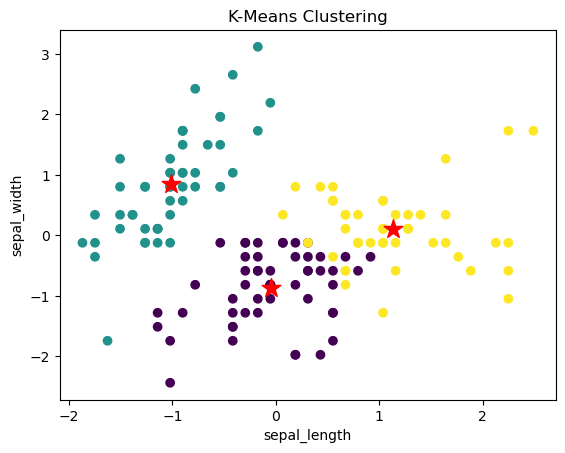

In [4]:
df=pd.read_csv('../data/IRIS.csv')
target='species'
features=df.drop(columns=[target]).columns.tolist()
scaler=StandardScaler()
df_scaled=pd.DataFrame(columns=features,index=df.index)
df_scaled[features]=scaler.fit_transform(df[features])
kmeans=do_clustering(df=df_scaled,n_clusters=3)
plot_clusters(data=df_scaled,feature_num=[0,1],model=kmeans)

* Instead, wecan also use PCA to plot in reduced two dimensional space:

/Users/fariborzparhizgar/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


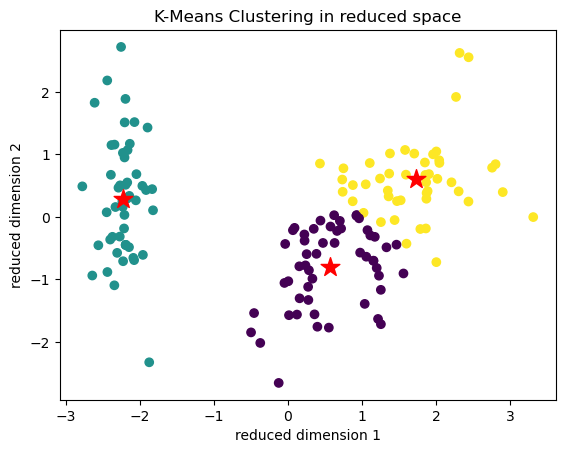

In [11]:
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(df_scaled)
centroids_reduced = pca.transform(kmeans.cluster_centers_)
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=kmeans.labels_, cmap='viridis')
plt.scatter(centroids_reduced[:, 0], centroids_reduced[:, 1], marker='*', c='red', s=200)
plt.xlabel('reduced dimension 1')
plt.ylabel('reduced dimension 2')
plt.title('K-Means Clustering in reduced space')
plt.show()

* Now, wecan use the accuracy as an indicator of performance

In [14]:
target_keys=list(df[target].unique())
target_values=[1,0,2]
df_copy=df.copy()
df_copy[target].replace(target_keys,target_values, inplace=True)
df_copy[target+'_pred']=kmeans.labels_
print("Accuracy: ", accuracy_score(df_copy[target], df_copy[target+'_pred']))


Accuracy:  0.8333333333333334


* Not bad, but it is not the goal of this study, so let'sgo to find the anomalies.

[8,
 14,
 15,
 32,
 33,
 41,
 57,
 60,
 62,
 68,
 85,
 93,
 98,
 106,
 108,
 109,
 114,
 117,
 118,
 119,
 122,
 131]

/Users/fariborzparhizgar/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


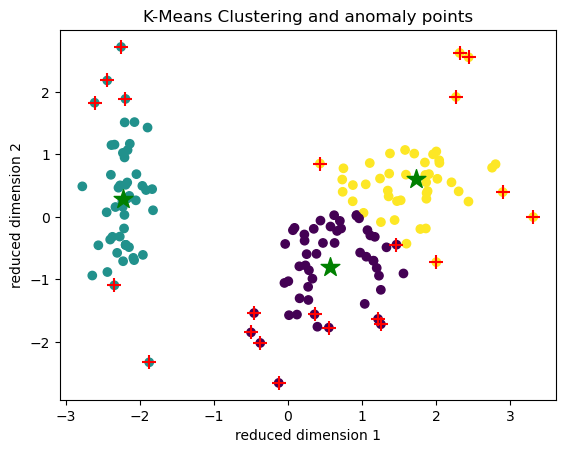

In [19]:
anomalies=find_anomaly(data=df_scaled,kmeans=kmeans,threshold=0.95)

# anomalies is the list of rows of dataframe where the package found them as anomaly.
display(anomalies)
anomaly_plot_pca(data=df_scaled,kmeans=kmeans,anomalies=anomalies)

* One can also play with threshold to include more or less data into anomalies

/Users/fariborzparhizgar/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


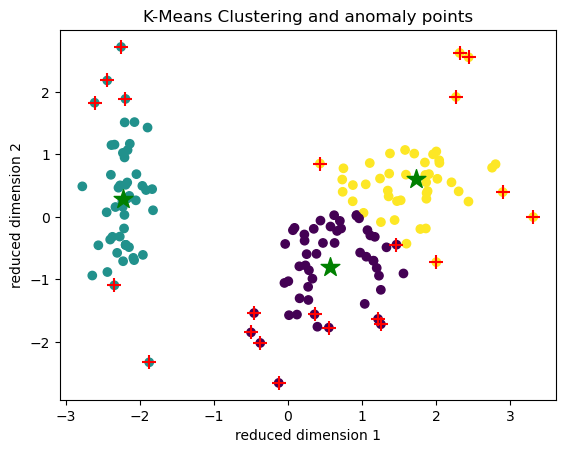

In [25]:
anomalies=find_anomaly(data=df_scaled,kmeans=kmeans,threshold=0.99)
anomaly_plot_pca(data=df_scaled,kmeans=kmeans,anomalies=anomalies)

* Let's look deeper into anomalies:

In [27]:
df_anomaly=df_copy.iloc[anomalies,:]
display(df_copy.iloc[anomalies,:])
print("Accuracy of lustering for only anomalies: ", accuracy_score(df_anomaly[target], df_anomaly[target+'_pred']))

,sepal_length,sepal_width,petal_length,petal_width,species,species_pred
8,4.4,2.9,1.4,0.2,1,1
14,5.8,4.0,1.2,0.2,1,1
15,5.7,4.4,1.5,0.4,1,1
32,5.2,4.1,1.5,0.1,1,1
33,5.5,4.2,1.4,0.2,1,1
41,4.5,2.3,1.3,0.3,1,1
57,4.9,2.4,3.3,1.0,0,0
60,5.0,2.0,3.5,1.0,0,0
62,6.0,2.2,4.0,1.0,0,0
68,6.2,2.2,4.5,1.5,0,0


Accuracy of lustering for only anomalies:  0.8181818181818182


This accuracy is similar to the overal accuracy. So I conclude, the problem of prediction has nothing to do with the outliers.

In [9]:
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0], dtype=int32)

## B) reconstruction-based anomaly detection

* Thismethod is very smart. It is suitable for places where the data has a pattern. For example there is a relation between features X1,X2. Then the distance from a centroid is not a good metric for anomaly, but it is the deviation from that relation which determines the anomaly.

In [29]:
def find_anomaly_reconstruction(data:pd.DataFrame,n_components:int,threshold:Union[float,str]):
    pca=PCA(n_components=n_components)
    df_reduced = pd.DataFrame(data=pca.fit_transform(data),index=data.index)
    df_reconstructed = pd.DataFrame(data=pca.inverse_transform(df_reduced),columns=data.columns,index=data.index)
    reconstruction_errors = np.mean(np.square(data - df_reconstructed), axis=1)
    ###
    if isinstance(threshold,float) or isinstance(threshold,int):
        mean_error = np.mean(reconstruction_errors)
        std_error = np.std(reconstruction_errors)
        threshold = mean_error + threshold * std_error
    elif isinstance(threshold,str) and threshold.endswith('%'):
        percentile=int(threshold.replace('%',''))
        threshold = np.percentile(reconstruction_errors, percentile)
    
    ###
    anomalies = np.where(reconstruction_errors > threshold)[0]
    return list(anomalies)

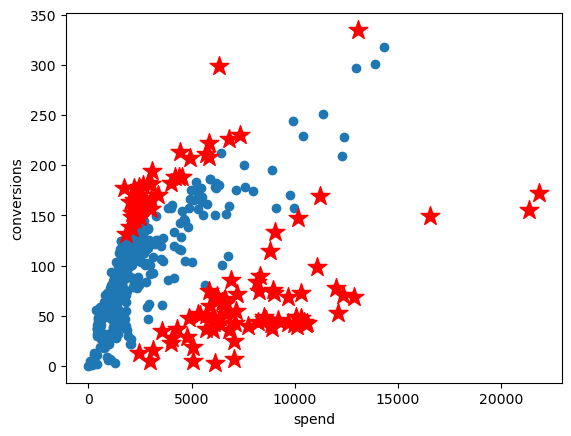

In [30]:
df_curve=pd.read_csv('../data/curve_dr.csv')
features=['spend','conversions']
df_original=df_curve[features]

scaler=StandardScaler()
df_scaled=pd.DataFrame(columns=df_original.columns,index=df_original.index,data=scaler.fit_transform(df_original))


anomalies=find_anomaly_reconstruction(data=df_scaled,n_components=1,threshold=0)
plt.scatter(df_original.iloc[:, 0], df_original.iloc[:, 1])
plt.scatter(df_original.iloc[anomalies, 0], df_original.iloc[anomalies, 1], marker='*', c='red', s=200)
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.show()


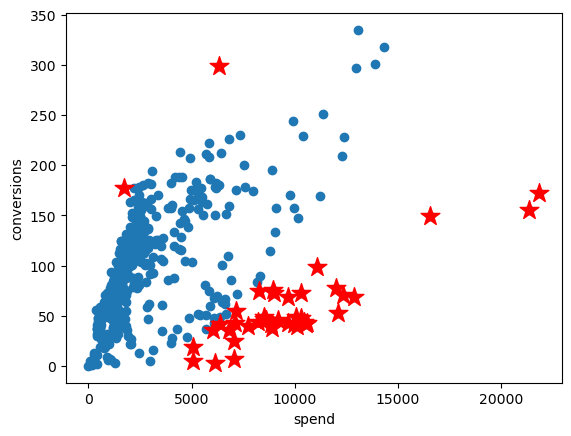

In [34]:
anomalies=find_anomaly_reconstruction(data=df_scaled,n_components=1,threshold=1)
plt.scatter(df_original.iloc[:, 0], df_original.iloc[:, 1])
plt.scatter(df_original.iloc[anomalies, 0], df_original.iloc[anomalies, 1], marker='*', c='red', s=200)
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.show()

## C) Isolation Forest

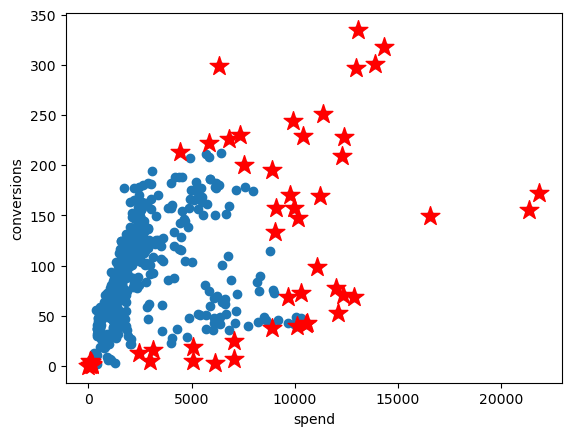

In [35]:
from sklearn.ensemble import IsolationForest
threshold = -0.0 
contamination=0.1
isolation_forest = IsolationForest(contamination=contamination) # it is somehow the percentage of expected anomalies in the dataset (5% anomaly)

##

df_curve=pd.read_csv('../data/curve_dr.csv')
features=['spend','conversions']
df_original=df_curve[features]
##

isolation_forest.fit(df_original)
anomaly_scores = isolation_forest.decision_function(df_original)

anomalies = np.where(anomaly_scores < threshold)[0]
anomalies

plt.scatter(df_original.iloc[:, 0], df_original.iloc[:, 1])
plt.scatter(df_original.iloc[anomalies, 0], df_original.iloc[anomalies, 1], marker='*', c='red', s=200)
#plt.scatter(data_reduced[anomalies, 0], data_reduced[anomalies, 1], marker='+', c='red', s=100)
plt.xlabel(features[0])
plt.ylabel(features[1])
#plt.title('K-Means Clustering and anomaly points')
plt.show()

